In [1]:
!wget -O train.zip "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip"

--2025-05-13 23:52:58--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.202.25, 52.216.37.9, 3.5.7.133, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.202.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11165358566 (10G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]  10.40G  47.1MB/s    in 3m 52s  

2025-05-13 23:56:50 (46.0 MB/s) - ‘train.zip’ saved [11165358566/11165358566]



In [5]:
!unzip -q train.zip

replace ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!wget -O train_labels.zip "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip"

--2025-05-13 23:59:22--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.136.25, 52.217.104.156, 52.217.133.137, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.136.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27402895 (26M) [application/zip]
Saving to: ‘train_labels.zip’

train_labels.zip    100%[===================>]  26.13M  30.2MB/s    in 0.9s    

2025-05-13 23:59:24 (30.2 MB/s) - ‘train_labels.zip’ saved [27402895/27402895]



In [4]:
!unzip -q train_labels.zip

In [8]:
!wget -O val.zip "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip"

--2025-05-14 00:29:24--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.28.57, 52.216.34.201, 3.5.29.135, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.28.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239231159 (228M) [application/zip]
Saving to: ‘val.zip’

val.zip             100%[===================>] 228.15M  51.8MB/s    in 4.7s    

2025-05-14 00:29:30 (48.2 MB/s) - ‘val.zip’ saved [239231159/239231159]



In [9]:
!unzip -q val.zip

In [10]:
!wget -O val_labels.zip "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip"

--2025-05-14 00:30:30--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.7.166, 3.5.24.249, 52.216.26.164, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.7.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 759706 (742K) [application/zip]
Saving to: ‘val_labels.zip’

val_labels.zip      100%[===================>] 741.90K  2.36MB/s    in 0.3s    

2025-05-14 00:30:31 (2.36 MB/s) - ‘val_labels.zip’ saved [759706/759706]



In [11]:
!unzip -q val_labels.zip

In [12]:
!wget -O test.zip "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Test_Input.zip"

--2025-05-14 00:31:44--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Test_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 16.182.96.113, 3.5.11.154, 3.5.29.150, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|16.182.96.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2370457338 (2.2G) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]   2.21G  50.9MB/s    in 46s     

2025-05-14 00:32:30 (49.6 MB/s) - ‘test.zip’ saved [2370457338/2370457338]



In [13]:
!unzip -q test.zip

In [14]:
!wget -O test_labels.zip "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Test_GroundTruth.zip"

--2025-05-14 00:33:17--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Test_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.233.121, 3.5.29.57, 16.15.192.51, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.233.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9680101 (9.2M) [application/zip]
Saving to: ‘test_labels.zip’

test_labels.zip     100%[===================>]   9.23M  13.4MB/s    in 0.7s    

2025-05-14 00:33:19 (13.4 MB/s) - ‘test_labels.zip’ saved [9680101/9680101]



In [15]:
!unzip -q test_labels.zip

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import random

In [20]:
image_size = (128, 128)
batch_size = 32
num_classes = 1

def load_data(image_dir, mask_dir, image_size, pc):
    images = []
    masks = []

    valid_extensions = ('.jpg', '.jpeg', '.png')

    image_filenames = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)])
    random.shuffle(image_filenames)
    image_filenames = image_filenames[:int(len(image_filenames) * pc)]

    for image_file in image_filenames:
        base_name = os.path.splitext(image_file)[0]
        mask_file = base_name + '_segmentation.png'

        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)


        image = load_img(image_path, target_size=image_size)
        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")

        image = img_to_array(image) / 255.0
        mask = img_to_array(mask) / 255.0
        mask = (mask > 0.5).astype(np.float32)

        images.append(image)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)


    return images, masks



In [21]:
image_dir = r'/content/ISIC2018_Task1-2_Training_Input'
mask_dir = r'ISIC2018_Task1_Training_GroundTruth'
X_train, y_train = load_data(image_dir, mask_dir, image_size, 0.7)

In [22]:
image_dir = r'/content/ISIC2018_Task1-2_Validation_Input'
mask_dir = r'/content/ISIC2018_Task1_Validation_GroundTruth'
X_val, y_val = load_data(image_dir, mask_dir, image_size, 1.0)

In [23]:
image_dir = r'/content/ISIC2018_Task1-2_Test_Input'
mask_dir = r'/content/ISIC2018_Task1_Test_GroundTruth'
X_test, y_test = load_data(image_dir, mask_dir, image_size, 1.0)

In [24]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model(input_size=(128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 16, 16,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callback para guardar el mejor modelo
checkpoint_cb = ModelCheckpoint(
    filepath='best_segmenter.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Callback para detener el entrenamiento si no mejora
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,                      # número de epochs sin mejora antes de detener
    restore_best_weights=True,      # recupera los mejores pesos
    mode='min',
    verbose=1
)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb]
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.7477 - loss: 0.4906
Epoch 1: val_loss improved from inf to 0.47740, saving model to best_segmenter.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7487 - loss: 0.4897 - val_accuracy: 0.7725 - val_loss: 0.4774
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8350 - loss: 0.3991
Epoch 2: val_loss improved from 0.47740 to 0.43669, saving model to best_segmenter.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - accuracy: 0.8351 - loss: 0.3989 - val_accuracy: 0.7962 - val_loss: 0.4367
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8528 - loss: 0.3709
Epoch 3: val_loss improved from 0.43669 to 0.39535, saving model to best_segmenter.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 62s 803ms/step - accuracy: 0.8527 - loss: 0.3710 - val_accuracy: 0.8336 - val_loss: 0.3954
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8618 - loss: 0.3503
Epoch 4: val_loss improved from 0.39535 to 0.38296, s

In [26]:
from tensorflow.keras.models import load_model

model = load_model('best_segmenter.keras')

In [27]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss}, Validation Accuracy: {acc}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.8167 - loss: 0.4315
Validation Loss: 0.4006706476211548, Validation Accuracy: 0.8342844247817993


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


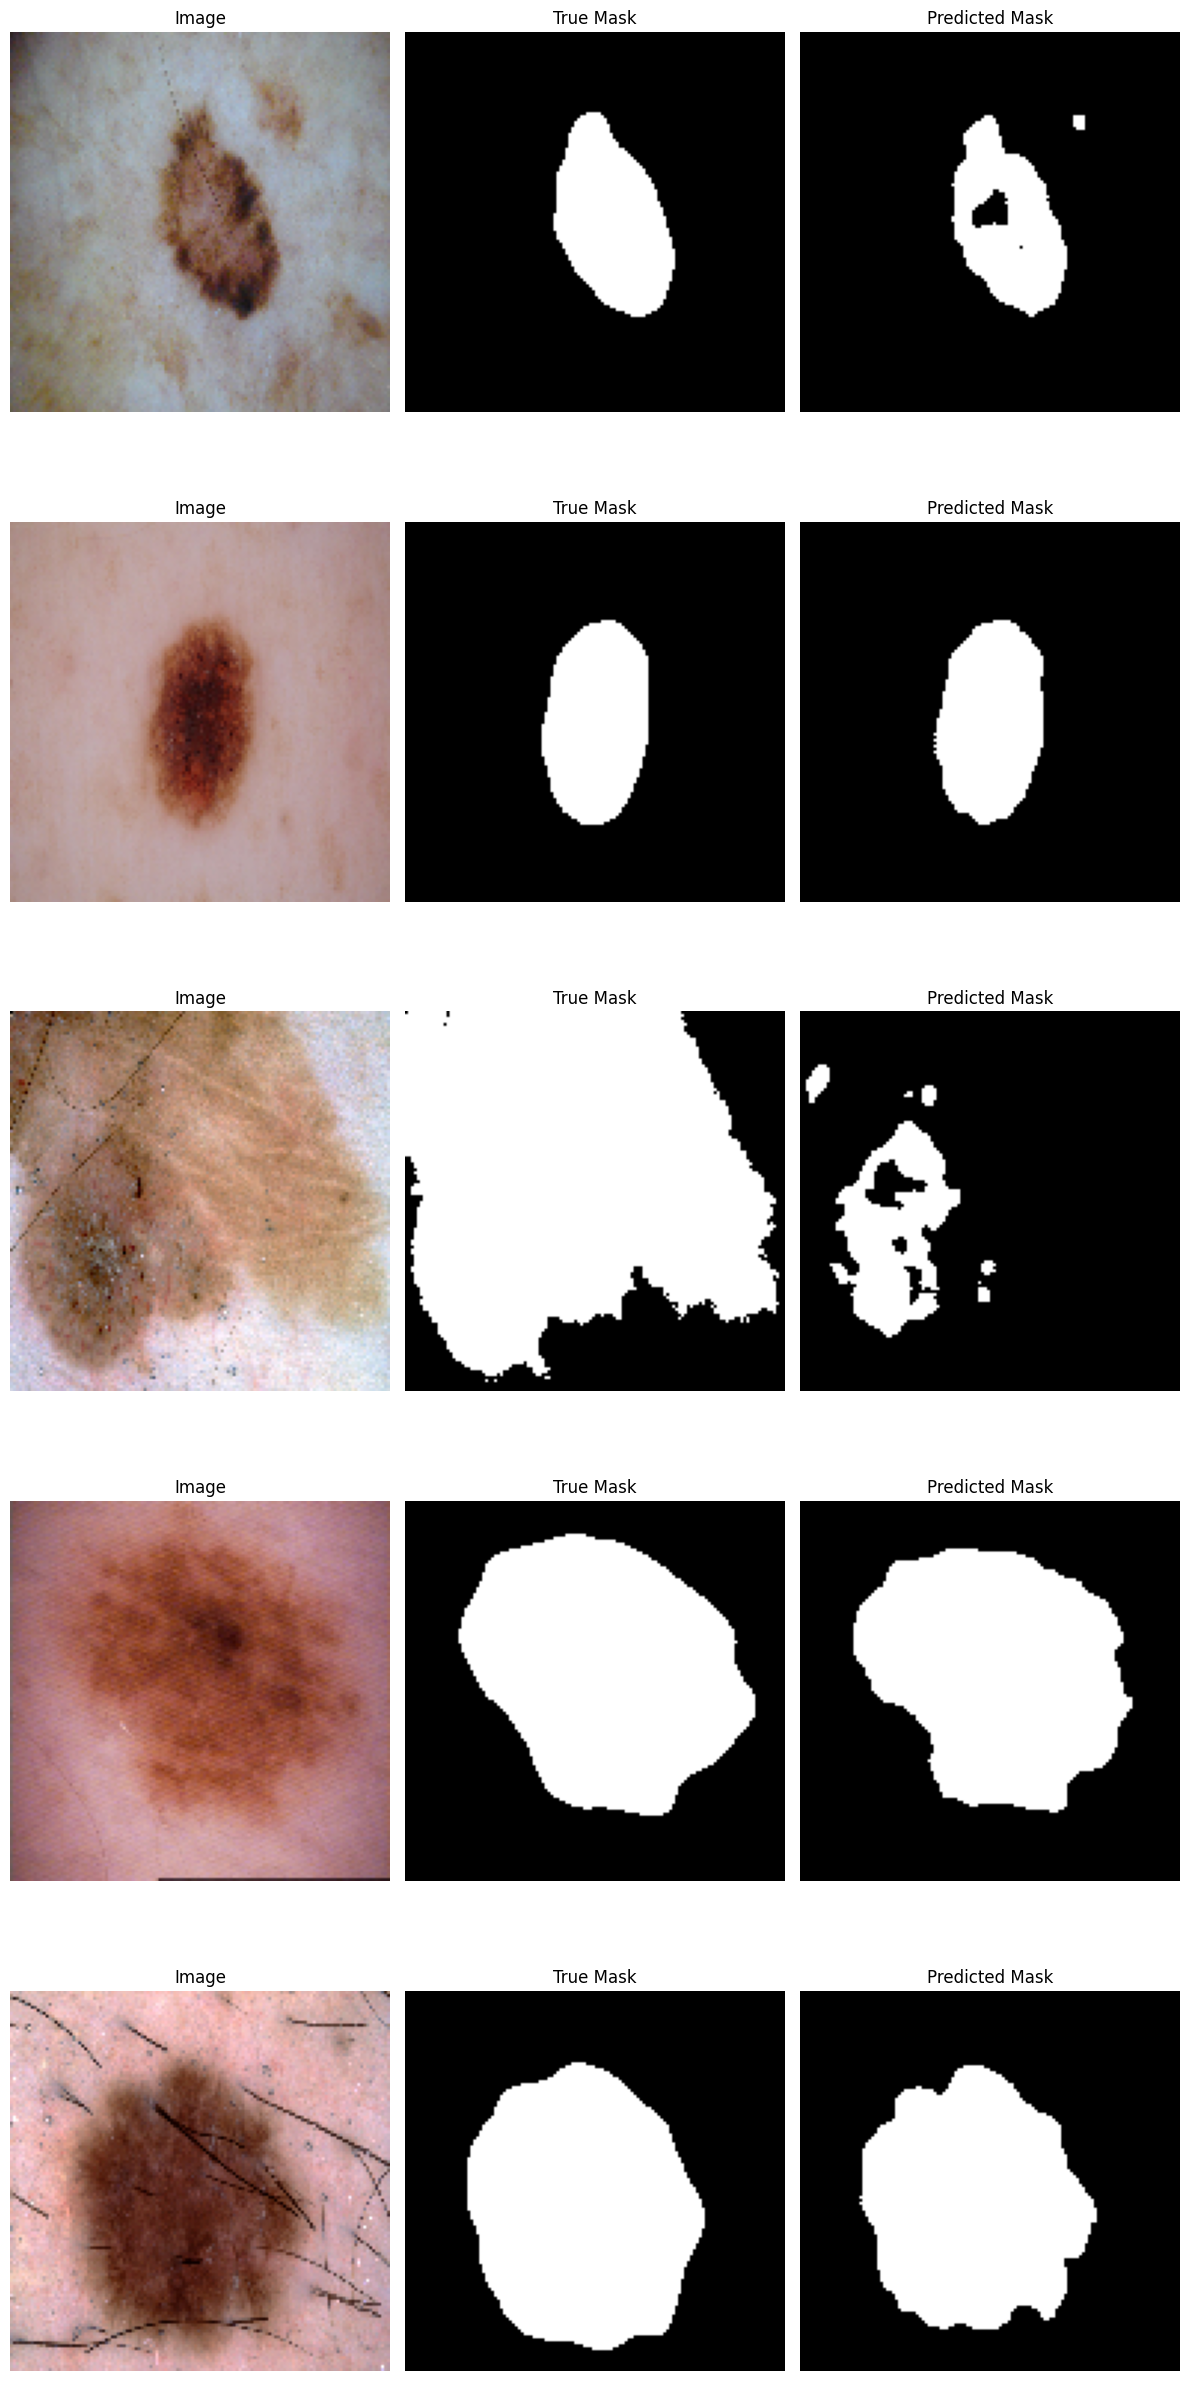

In [29]:
def visualize_predictions(images, masks, model, threshold=0.5):
    predictions = model.predict(images)
    predictions = (predictions > threshold).astype(np.uint8)

    plt.figure(figsize=(12, 5 * len(images)))

    for i in range(len(images)):
        plt.subplot(len(images), 3, 3 * i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(len(images), 3, 3 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(len(images), 3, 3 * i + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_predictions(X_test[:5], y_test[:5], model)